This notebook demonstrates the full optimization process for the two wedges and phase rotation in the middle, along with summarized findings about the various parameters

Updated: 7/14/2023

# Setup

In [1]:
from g4beam import *
from scan import *

import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm
import numpy as np
import pandas as pd
from tqdm import *
import pickle
import itertools
from tabulate import tabulate

# Initial distribution

The parameters of the initial beam are treated as constants, but some things are known about their effects:
- **Transverse emittance**: Should be as low as possible. For this test we use an "optimistic" value of 110 microns.
- **Momentum**: Decreasing this appears to slightly decreases x-emittance.
- **Beta**: Decreasing this decreases the y-emittance growth. There may also be an optimal value for x-emittance.
- **Alpha**: Increasing this decreases the y-emittance growth, but past a certain point increases the x-emittance. I believe 0.7 focuses the beam onto the wedge center with a VD distance of 24 mm.
- **Longitudinal emittance**: Effects not yet tested.
- **Standard deviation of momentum**: Decreasing this decreases the x-emittance.
- **Virtual detector distance**: Almost irrelevant. Should be more than 3x the length of the wedge to ensure accurate measurements.

In [13]:
t_emit = 0.145  # mm
momentum = 100  # MeV/c
beta = 0.03    # m
alpha = 0.7     # dimensionless
l_emit = 1      # mm
pz_std = 1    # MeV/c
vd_dist = 24    # mm

pre_w1 = gen_distribution((beta, alpha, t_emit, 0, 0), (beta, alpha, t_emit, 0, 0), momentum, pz_std, z_emit=l_emit, N=20000)
pre_w1["PDGid"] = -13
print_all_params(pre_w1)

-----------------------------
Twiss parameters for X
emit  = 0.14554438725218552 mm
beta  = 0.030143098840580876 m
gamma = 49.651441491843066 1/m
alpha = 0.7047327922453615
D     = -0.0005357375259280228 m
D'    = -0.005879881039590498

Twiss parameters for Y
emit  = 0.14494935147476823 mm
beta  = 0.03019222129409863 m
gamma = 49.22755629914996 1/m
alpha = 0.6973444439813331
D     = -0.002195715623165154 m
D'    = -0.07891931131362631

Z-emittance:  1.2477391328408236 mm
Z std: 152.31734176719726 mm
p std: 0.9963968226043882 MeV/c
Mean momentum: 100.00386331157253 MeV/c
-----------------------------


# First wedge

Determines the optimal length and angle for the first wedge

In [ ]:
# Function to optimize
def func(x):
    length, angle = x
    return emittances(cut_outliers(run_distribution(pre_w1, length, angle, vd_dist, axis=0)))[0]

start = time.time()
# Run optimization
optim_result = minimize(func, [7.5, 45], method="Nelder-Mead", bounds=((1, 10), (30, 70)), options=dict(fatol=1e-6))

# Get results
w1_length, w1_angle = optim_result.x
print(f"Length = {w1_length:.2f} mm\nAngle = {w1_angle:.1f} deg")
print("Time spent:", time.time()-start)

# Runs a single case with the optimal parameters
post_w1 = run_distribution(pre_w1, w1_length, w1_angle, vd_dist, axis=0)
print_all_params(post_w1)
print_all_params(cut_outliers(post_w1))

iter value


In [48]:
post_w1 = run_distribution(pre_w1, w1_length, w1_angle, vd_dist, axis=0)
print_all_params(post_w1)
print_all_params(cut_outliers(post_w1))

-----------------------------
Twiss parameters for X
emit  = 0.03142119281839697 mm
beta  = 0.04990641534545574 m
gamma = 261.15802264405437 1/m
alpha = -3.4689278961765853
D     = 0.016461200673959082 m
D'    = -0.26435550754296544

Twiss parameters for Y
emit  = 0.12744858575905774 mm
beta  = 0.022196140627734316 m
gamma = 66.7036223773988 1/m
alpha = -0.6932265017063536
D     = -8.062849835683117e-05 m
D'    = 0.007306529075906538

Z-emittance:  5.723828063033381 mm
Z std: 142.787554705198 mm
p std: 6.564891870963892 MeV/c
Mean momentum: 88.43903955354267 MeV/c
-----------------------------
-----------------------------
Twiss parameters for X
emit  = 0.030944350398933194 mm
beta  = 0.05051872993641898 m
gamma = 264.7226217117562 1/m
alpha = -3.517591595725265
D     = 0.016574361801152505 m
D'    = -0.26565337407238554

Twiss parameters for Y
emit  = 0.1272842668949593 mm
beta  = 0.022197403179251965 m
gamma = 66.63036433687252 1/m
alpha = -0.6921134741977002
D     = -0.0001303705953

In [21]:
print_all_params(run_distribution(pre_w1, w1_length, w1_angle, vd_dist, axis=0, noWedge=1))

-----------------------------
Twiss parameters for X
emit  = 0.14559073699077354 mm
beta  = 0.022501229381656062 m
gamma = 66.86320540374554 1/m
alpha = -0.710284676719457
D     = 0.00038365588304258876 m
D'    = -0.04007484214911991

Twiss parameters for Y
emit  = 0.1446393396335309 mm
beta  = 0.02238371926778117 m
gamma = 66.88083547433388 1/m
alpha = -0.7050119471697976
D     = -0.0003323009910932513 m
D'    = 0.06171602209176137

Z-emittance:  1.4375373708507695 mm
Z std: 153.81616883576498 mm
p std: 0.9954108161738489 MeV/c
Mean momentum: 100.00306232557438 MeV/c
-----------------------------


# Dispersion correction and transverse separation

We assume that dispersion correction and focusing can be done ideally. We thus remove the dispersion mathematically, propagate the beam in z while leaving x and y positions/momenta untouched, and consider only longitudinal motion in the RF cavity.

For the second wedge, we will re-add the negative of the original Px and Py, to represent refocusing the beam before the second wedge

In [ ]:
# Calculate dispersion correction
post_correct = remove_dispersion(post_w1)

# Ignore transverse momentums
no_transverse = remove_transverse(post_correct)

# Reverse transverse momentums in saved copy
reverse_transverse = post_correct.copy(deep=True)
reverse_transverse["Px"] *= -1
reverse_transverse["Py"] *= -1

# Phase rotation

The following are taken as constants, as they are primarily constrained by technical limitations. The optimal RF gradient is heavily dependent on both of these.
- **Drift length**: Longer drift length will give better results
- **RF frequency**: Lower frequency will usually give better results. There's an optimal point, but I believe it's lower than practical

We then optimize the RF phase, cavity length, and gradient

In [ ]:
drift_length = 16000
rf_freq = 0.025

# Function to optimize
def func(x):
    rf_phase, rf_length, rf_grad = x
    drift_to_start = drift_length-rf_length/2
    post_drift = recenter_t(z_prop(no_transverse, drift_to_start))
    post_cavity = run_g4beam(post_drift, "G4_RFCavity.g4bl", RF_length=rf_length, frfcool=rf_freq, ficool=rf_phase, Vrfcool=rf_grad, nparticles=len(no_transverse))
    pre_w2 = recombine_transverse(post_cavity, reverse_transverse)
    return np.std(p_total(cut_pz(pre_w2)))

# Run optimization
optim_result = minimize(func, [0, 4700, 7], method="Nelder-Mead", bounds=((-90, 90), (2000, 6000), (1, 10)), options=dict(fatol=1e-6))

# Get results
rf_phase, rf_length, rf_grad = optim_result.x
print(f"Phase = {rf_phase:.2f} deg\nLength = {rf_length:.0f} mm\nGradient = {rf_grad:.2f} MV/m\nFrequency = {rf_freq*1000:.1f} MHz")

# Runs a single case with the optimal parameters and add the transverse back in
drift_to_start = drift_length-rf_length/2
post_drift = recenter_t(z_prop(no_transverse, drift_to_start))
post_cavity = cut_pz(recenter_t(run_g4beam(post_drift, "G4_RFCavity.g4bl", RF_length=rf_length, frfcool=rf_freq, ficool=rf_phase, Vrfcool=rf_grad)))
pre_w2 = recombine_transverse(post_cavity, reverse_transverse)
print_all_params(pre_w2)

# Second wedge

Optimize the second wedge in the same way as the first

In [ ]:
# Function to optimize
def func(x):
    length, angle = x
    return emittances(cut_outliers(run_distribution(pre_w2, length, angle, vd_dist, axis=1)))[1]

# Run optimization
optim_result = minimize(func, [5.5, 45], method="Nelder-Mead", bounds=((1, 10), (30, 70)), options=dict(fatol=1e-6))

# Get results
w2_length, w2_angle = optim_result.x
print(f"Length = {w2_length:.2f} mm\nAngle = {w2_angle:.1f} deg")

# Runs a single case with the optimal parameters
post_w2 = run_distribution(pre_w2, w2_length, w2_angle, vd_dist, axis=1)
print_all_params(post_w2)

# Do cuts at this point
post_w2_cut = cut_outliers(post_w2)
print_all_params(post_w2_cut)

# Save/load result

In [33]:
# Parameter list
PARAMS = [
    "t_emit",
    "momentum",
    "beta",
    "alpha",
    "l_emit",
    "pz_std",
    "vd_dist",
    "w1_length",
    "w1_angle",
    "w2_length",
    "w2_angle",
    "drift_length",
    "rf_freq",
    "rf_phase",
    "rf_length",
    "rf_grad"
]

In [34]:
# Show parameters
{k:globals()[k] for k in PARAMS}

{'t_emit': 0.145,
 'momentum': 100,
 'beta': 0.03,
 'alpha': 1,
 'l_emit': 1,
 'pz_std': 1,
 'vd_dist': 24,
 'w1_length': 9.20751061747799,
 'w1_angle': 49.78231333988419,
 'w2_length': 6.724887901827298,
 'w2_angle': 42.245718529695516,
 'drift_length': 16000,
 'rf_freq': 0.025,
 'rf_phase': 0.001987066319906211,
 'rf_length': 5153.756925848655,
 'rf_grad': 4.046563465382562}

In [8]:
# Input parameters
parameters = {'t_emit': 0.145,
 'momentum': 100,
 'beta': 0.03,
 'alpha': 1,
 'l_emit': 1,
 'pz_std': 1,
 'vd_dist': 24,
 'w1_length': 9.20751061747799,
 'w1_angle': 49.78231333988419,
 'w2_length': 6.724887901827298,
 'w2_angle': 42.245718529695516,
 'drift_length': 16000,
 'rf_freq': 0.025,
 'rf_phase': 0.001987066319906211,
 'rf_length': 5153.756925848655,
 'rf_grad': 4.046563465382562}
globals().update(parameters)

In [232]:
# Save parameter set
parameters = {k:globals()[k] for k in PARAMS}
filename = "results/parameters/"+input("Enter run name to save: ")+".pkl"
with open(filename, "wb+") as file:
    pickle.dump(parameters, file)
    print("Saved to", filename)

Enter run name to save:  110_balanced


Saved to results/parameters/110_balanced.pkl


In [7]:
# Load parameter set
filename = "results/parameters/"+input("Enter run name to load: ")+".pkl"
with open(filename, "rb+") as file:
    parameters = pickle.load(file)
    globals().update(parameters)
    print("Loaded from", filename)

Enter run name to load:  110_a10


Loaded from results/parameters/110_a10.pkl


In [16]:
# View parameter set
filename = "results/parameters/"+input("Enter run name to view: ")+".pkl"
with open(filename, "rb+") as file:
    parameters = pickle.load(file)
    print("Viewing", filename)
    print(parameters)

Enter run name to view:  110_a10


Viewing results/parameters/110_a10.pkl
{'t_emit': 0.11, 'momentum': 100, 'beta': 0.03, 'alpha': 1.0, 'l_emit': 1, 'pz_std': 0.8, 'vd_dist': 24, 'w1_length': 6.60734829348803, 'w1_angle': 52.14492904686631, 'w2_length': 4.848777306079863, 'w2_angle': 50.149723291397095, 'drift_length': 16000, 'rf_freq': 0.025, 'rf_phase': 131.41817209174707, 'rf_length': 5772.41333322533, 'rf_grad': 5.630217759927936}


In [255]:
vd_dist=36

# Analyze single case

In [8]:
# Tweak parameters
rf_phase += 180
rf_phase

311.41817209174707

In [12]:
# Run best case
pre_w1 = gen_distribution((beta, alpha, t_emit, 0, 0), (beta, alpha, t_emit, 0, 0), momentum, pz_std, z_emit=l_emit, N=100000)
pre_w1["PDGid"] = -13
print("Running first wedge")
post_w1 = run_distribution(pre_w1, w1_length, w1_angle, vd_dist, axis=0)
post_correct = remove_dispersion(post_w1)
reverse_transverse = post_correct.copy(deep=True)
reverse_transverse["Px"] *= -1
reverse_transverse["Py"] *= -1
drift_to_start = drift_length-rf_length/2
post_drift = recenter_t(z_prop(post_correct, drift_to_start))
no_transverse = remove_transverse(post_drift)
print("Running RF cavity")
post_cavity = cut_pz(recenter_t(run_g4beam(no_transverse, "G4_RFCavity.g4bl", RF_length=rf_length, frfcool=rf_freq, ficool=rf_phase, Vrfcool=rf_grad, nparticles=len(no_transverse))), tails=0.15)
pre_w2 = recombine_transverse(post_cavity, reverse_transverse)
print("Running second wedge")
post_w2 = run_distribution(pre_w2, w2_length, w2_angle, vd_dist, axis=1)
post_w2_cut = recenter_t(cut_outliers(post_w2))
print_all_params(post_w2_cut)
beep()

Running first wedge
Running RF cavity
Running second wedge
-----------------------------
Twiss parameters for X
emit  = 0.031119272104071297 mm
beta  = 0.06091213434359616 m
gamma = 327.57715260920526 1/m
alpha = -4.353552977468474
D     = -4.968255702418962e-06 m
D'    = -0.00013534769920678336

Twiss parameters for Y
emit  = 0.041156055440355714 mm
beta  = 0.044763813175619886 m
gamma = 244.95453330518558 1/m
alpha = -3.1567544987525533
D     = 0.010340242416044226 m
D'    = 0.10759225342301776

Z-emittance:  37.01994174531339 mm
Z std: 736.2556383613062 mm
p std: 9.718287396518704 MeV/c
Mean momentum: 68.5166812511317 MeV/c
-----------------------------


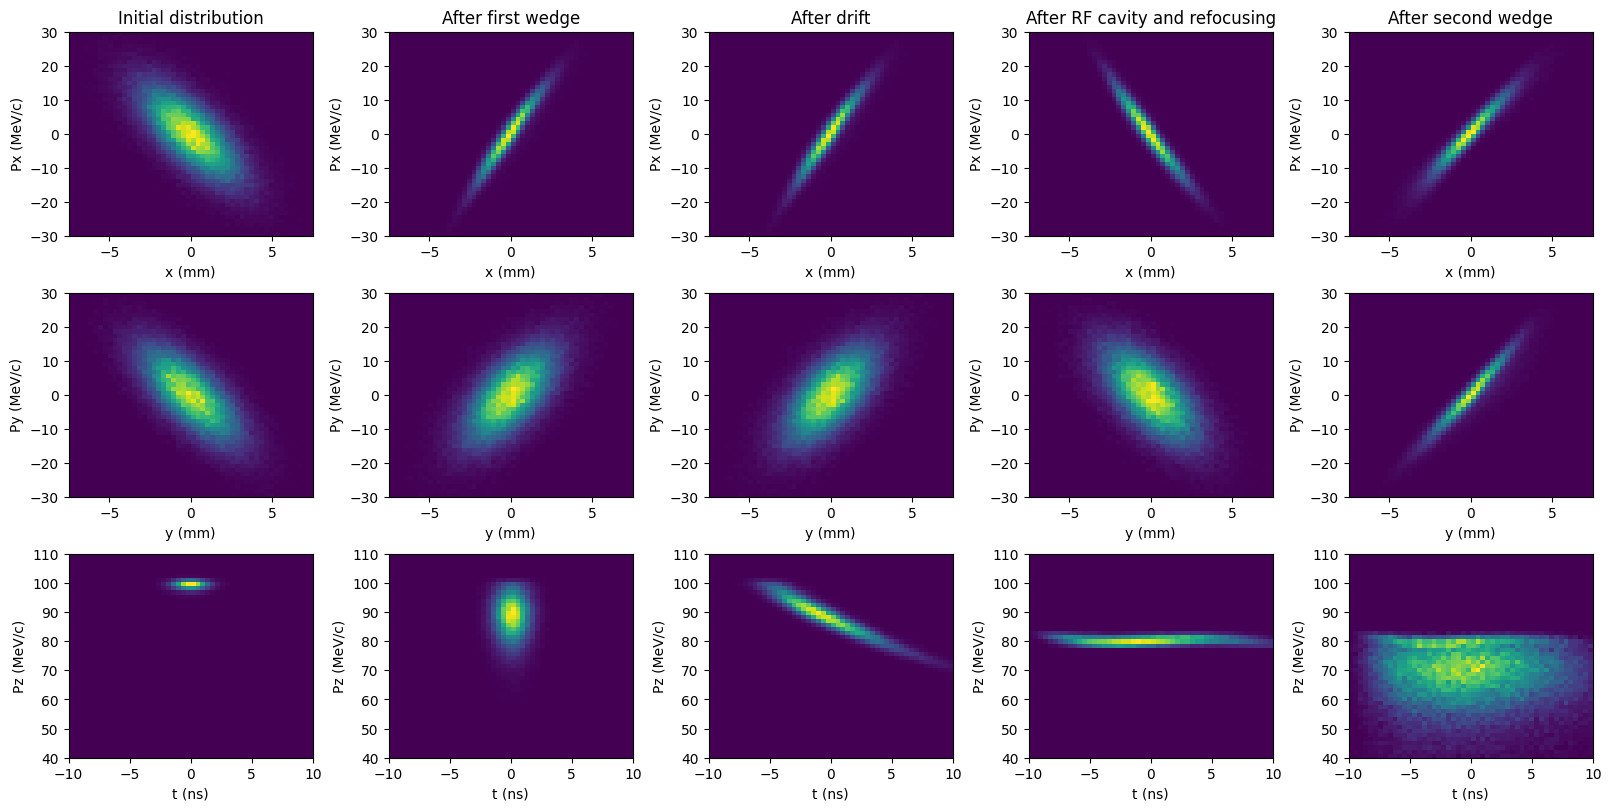

In [13]:
# Make some phase space plots
PLOT_TARGETS = [pre_w1, post_correct, post_drift, pre_w2, remove_dispersion(post_w2_cut)]
PLOT_TITLES = ["Initial distribution", "After first wedge", "After drift", "After RF cavity and refocusing", "After second wedge"]
PLOT_AXES = [("x", "Px"), ("y", "Py"), ("t", "Pz")]
PLOT_LABELS = [("x (mm)", "Px (MeV/c)"), ("y (mm)", "Py (MeV/c)"), ("t (ns)", "Pz (MeV/c)")]
T_RANGES = [[-7.5, 7.5], [-30, 30]]
L_RANGES = [[-10, 10], [40, 110]]

fig, axes = plt.subplots(nrows = len(PLOT_AXES), ncols = len(PLOT_TARGETS), layout="constrained")
fig.set_size_inches(16, 8)
for i, df in enumerate(PLOT_TARGETS):
    axes[0][i].set_title(PLOT_TITLES[i])
    for j, ((xaxis, yaxis), (xlabel, ylabel)) in enumerate(zip(PLOT_AXES, PLOT_LABELS)):
        ax = axes[j][i]
        ax.hist2d(df[xaxis], df[yaxis], bins=50, range=L_RANGES if j == 2 else T_RANGES)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
# fig.suptitle(f"temit={t_emit*1000:.0f} μm, σP={pz_std:.2f} MeV/c")

In [14]:
SAMPLE_DISTS = [pre_w1, post_correct, pre_w2, remove_dispersion(post_w2_cut)]
SAMPLE_TITLES = ["Initial distribution", "After first wedge", "After RF cavity + 10% cut", "After second wedge + 4 sigma cut"]
VARIABLE_NAMES = ["x emit (μm)", "y emit (μm)", "z-emit (mm)", "sigma-p (MeV/c)", "sigma-t (ns)", "Beam remaining"]
VARIABLE_FUNCS = [
    lambda df: emittances(df)[0]*1000,
    lambda df: emittances(df)[1]*1000,
    lambda df: emittances(df)[2],
    lambda df: np.std(p_total(df)),
    lambda df: np.std(df["t"]),
    lambda df: len(df) / len(pre_w1)
]
table = [[n] + [y(x) for y in VARIABLE_FUNCS] for n, x in zip(SAMPLE_TITLES, SAMPLE_DISTS)]
print(tabulate(
    table,
    headers=["Stage"] + VARIABLE_NAMES,
    # tablefmt="latex_raw",
    floatfmt=(None, ".1f", ".1f", ".3f", ".3f", ".3f", ".1%")
))

Stage                               x emit (μm)    y emit (μm)    z-emit (mm)    sigma-p (MeV/c)    sigma-t (ns)    Beam remaining
--------------------------------  -------------  -------------  -------------  -----------------  --------------  ----------------
Initial distribution                      110.2          110.3          1.408              0.801           0.938            100.0%
After first wedge                          34.4          114.8          7.313              6.431           0.938            100.0%
After RF cavity + 10% cut                  27.9          117.8          5.098              1.438           4.543             84.0%
After second wedge + 4 sigma cut           31.1           41.3         37.014              9.719           4.543             82.2%


## Anomaly investigation

This is going insane

In [137]:
momentum = 100
pre_w1 = gen_distribution((beta, alpha, t_emit, 0, 0), (beta, alpha, t_emit, 0, 0), momentum, pz_std, z_emit=l_emit, N=12000)
pre_w1["PDGid"] = -13
run_distribution(pre_w1, w1_length, w1_angle, vd_dist, axis=0, debug=True)

abshalfangle3=52.14492904686631 absoffset3=2.5676820987176616 abshgt=9.42664173764817 absLEN3=24 wedgeAxis=0 nparticles=12000


In [141]:
momentums = list(range(50, 101, 10))
results = list() #  Yeah we're back to the old days now
for momentum in tqdm(momentums):
    pre_w1 = gen_distribution((beta, alpha, t_emit, 0, 0), (beta, alpha, t_emit, 0, 0), momentum, pz_std, z_emit=l_emit, N=12000)
    pre_w1["PDGid"] = -13
    results.append(run_distribution(pre_w1, w1_length, w1_angle, vd_dist, axis=0))
beep()

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:34<00:00,  5.76s/it]


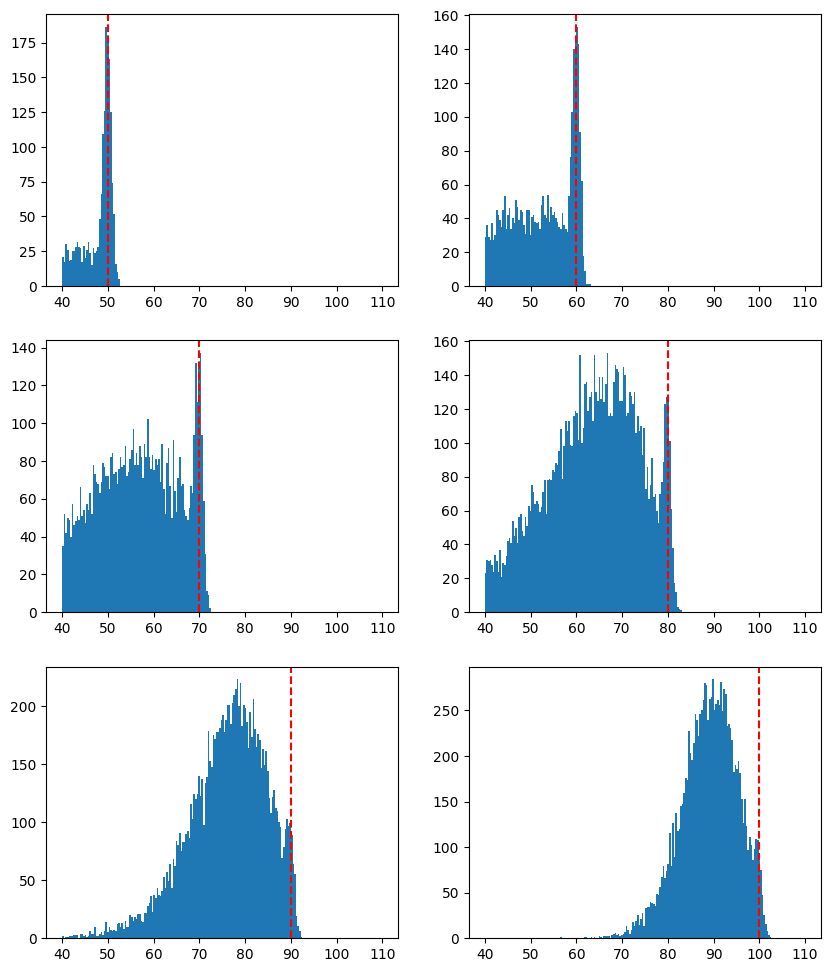

In [142]:
fig, axs = plt.subplots(nrows = 3, ncols = 2)
axs = axs.flatten()
fig.set_size_inches(10, 12)
for momentum, x, ax in zip(momentums, results, axs):
    ax.hist(p_total(x), bins=200, range=(40, 110))
    ax.axvline(momentum, color="red", linestyle="--")
pass

In [140]:
results[0]["PDGid"]

0       13
1       13
2       13
3       13
4       13
        ..
3023    13
3024    13
3025    13
3026    13
3027    13
Name: PDGid, Length: 3028, dtype: int64

In [111]:
angles = [30, 40, 50, 60]
momentum = 70
results1 = list() #  Yeah we're back to the old days now
for angle in tqdm(angles):
    pre_w1 = gen_distribution((beta, alpha, t_emit, 0, 0), (beta, alpha, t_emit, 0, 0), momentum, pz_std, z_emit=l_emit, N=12000)
    results1.append(run_distribution(pre_w1, w1_length, angle, vd_dist, axis=0))
beep()

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:18<00:00,  4.67s/it]


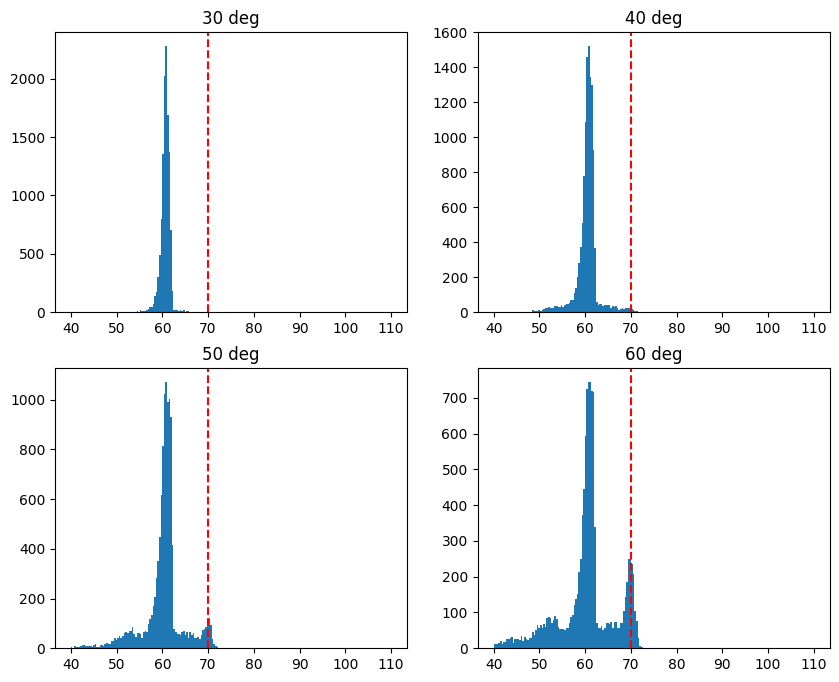

In [112]:
fig, axs = plt.subplots(nrows = 2, ncols = 2)
axs = axs.flatten()
fig.set_size_inches(10, 8)
for angle, x, ax in zip(angles, results1, axs):
    ax.hist(p_total(x), bins=200, range=(40, 110))
    ax.axvline(momentum, color="red", linestyle="--")
    ax.set_title(f"{angle} deg")
pass

In [115]:
lengths = [3, 6, 9, 12]
momentum = 70
results2 = list() #  Yeah we're back to the old days now
for length in tqdm(lengths):
    pre_w1 = gen_distribution((beta, alpha, t_emit, 0, 0), (beta, alpha, t_emit, 0, 0), momentum, pz_std, z_emit=l_emit, N=12000)
    results2.append(run_distribution(pre_w1, length, w1_angle, 40, axis=0))
beep()

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.01s/it]


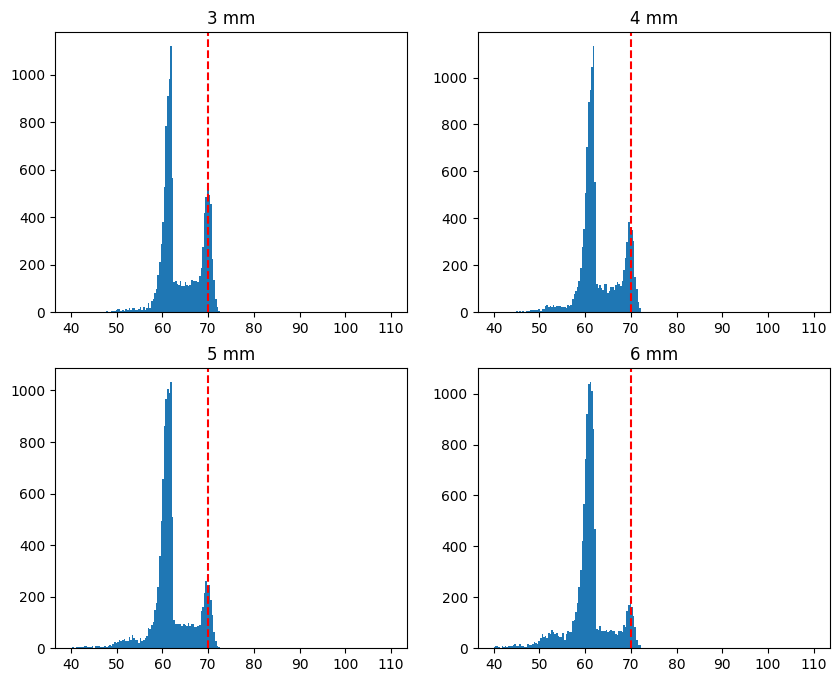

In [114]:
fig, axs = plt.subplots(nrows = 2, ncols = 2)
axs = axs.flatten()
fig.set_size_inches(10, 8)
for length, x, ax in zip(lengths, results2, axs):
    ax.hist(p_total(x), bins=200, range=(40, 110))
    ax.axvline(momentum, color="red", linestyle="--")
    ax.set_title(f"{length} mm")
pass

In [297]:
fig, ax = plt.subplots()
ax.hist(p_total(post_w2_cut), bins=200)
select_bottom, select_top = 60.5, 62.5
ax.axvline(select_bottom, color="r", linestyle="--")
ax.axvline(select_top, color="r", linestyle="--")
anomaly = post_w2_cut[(p_total(post_w2_cut) < select_top) & (p_total(post_w2_cut) > select_bottom)]
pre_anomaly = pre_w2.loc[anomaly["EventID"]]
post_anomaly = run_distribution(pre_anomaly, w2_length, w2_angle, vd_dist, axis=1)

<IPython.core.display.Javascript object>

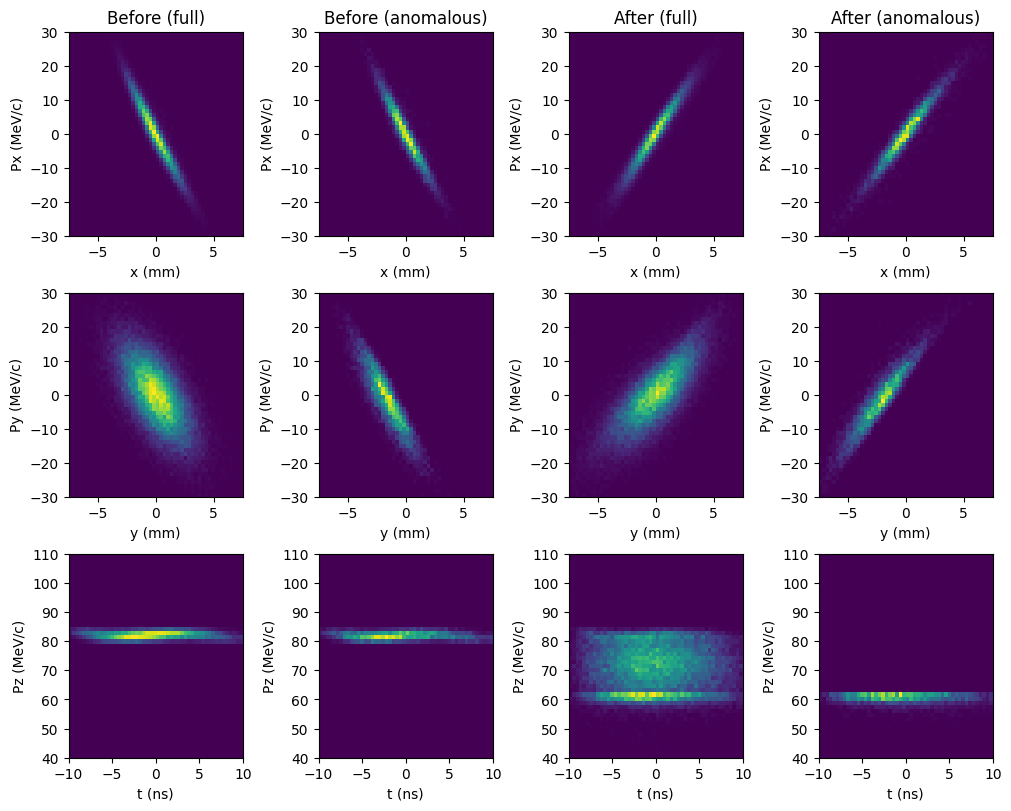

In [254]:
# Show the anomaly
PLOT_TARGETS = [pre_w2, pre_anomaly, post_w2_cut, post_anomaly]
PLOT_TITLES = ["Before (full)", "Before (anomalous)", "After (full)", "After (anomalous)"]
PLOT_AXES = [("x", "Px"), ("y", "Py"), ("t", "Pz")]
PLOT_LABELS = [("x (mm)", "Px (MeV/c)"), ("y (mm)", "Py (MeV/c)"), ("t (ns)", "Pz (MeV/c)")]
T_RANGES = [[-7.5, 7.5], [-30, 30]]
L_RANGES = [[-10, 10], [40, 110]]

fig, axes = plt.subplots(nrows = len(PLOT_AXES), ncols = len(PLOT_TARGETS), layout="constrained")
fig.set_size_inches(10, 8)
for i, df in enumerate(PLOT_TARGETS):
    axes[0][i].set_title(PLOT_TITLES[i])
    for j, ((xaxis, yaxis), (xlabel, ylabel)) in enumerate(zip(PLOT_AXES, PLOT_LABELS)):
        ax = axes[j][i]
        ax.hist2d(df[xaxis], df[yaxis], bins=50, range=L_RANGES if j == 2 else T_RANGES)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
# fig.suptitle(f"temit={t_emit*1000:.0f} μm, σP={pz_std:.2f} MeV/c")

In [294]:
run_distribution(pre_w1, w2_length, w2_angle, vd_dist, axis=1, debug=True)

abshalfangle3=50.149723291397095 absoffset3=2.023531266248378 abshgt=15.123813424798636 absLEN3=36 wedgeAxis=1 nparticles=50000


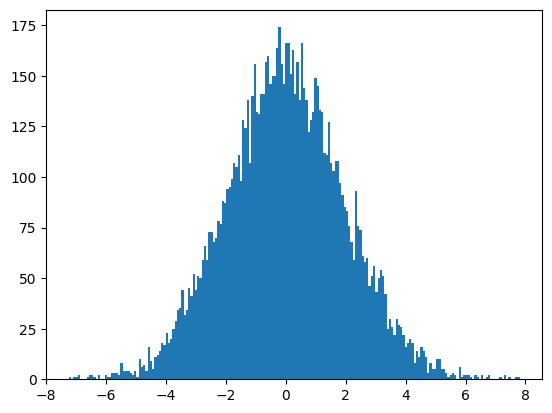

In [128]:
fig, ax = plt.subplots()
ax.hist(post_w2_cut["y"], bins=200)
pass

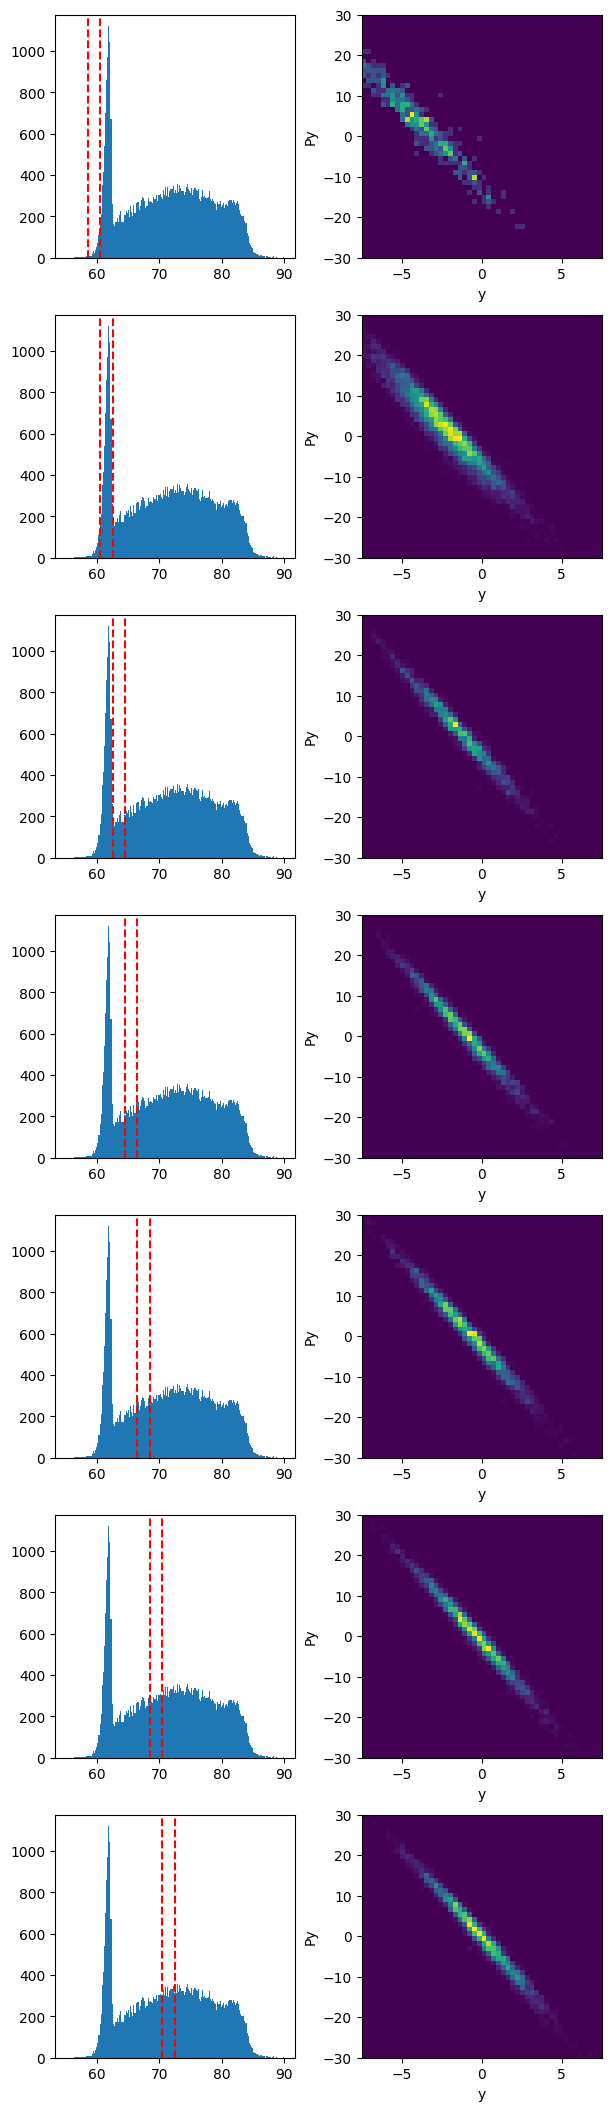

In [281]:
p_ranges = [(58.5+2*i, 60.5+2*i) for i in range(7)]

fig, axes = plt.subplots(ncols = 2, nrows = len(p_ranges), layout="constrained")
fig.set_size_inches(6, 3*len(p_ranges))
for i, r in enumerate(p_ranges):
    ax = axes[i][0]
    ax.hist(p_total(post_w2_cut), bins=200, range=(55, 90))
    select_bottom, select_top = r
    ax.axvline(select_bottom, color="r", linestyle="--")
    ax.axvline(select_top, color="r", linestyle="--")

    selected = post_w2_cut[(p_total(post_w2_cut) < select_top) & (p_total(post_w2_cut) > select_bottom)]
    pre_selected = pre_w2.loc[selected["EventID"]]

    ax = axes[i][1]
    ax.hist2d(pre_selected["y"], pre_selected["Py"], bins=50, range=T_RANGES)
    ax.set_xlabel("y")
    ax.set_ylabel("Py")

## Two optimal wedges (regenerated)

In [35]:
# Range to scan
angles = np.linspace(30, 60, 20)
lengths = np.linspace(5, 11, 20)

In [38]:
def fun(length, angle):
    return run_distribution(pre_w2, length, angle, 24, axis=1)

results = run_scan(fun, (lengths, angles), filename="results/second_wedge_length_angle.pkl")
beep()

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [29:05<00:00,  4.36s/it]


In [39]:
def fun(length, angle):
    return run_distribution(pre_w1, length, angle, 24, axis=0)

results = run_scan(fun, (lengths, angles), filename="results/first_wedge_length_angle.pkl")
beep()

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [32:36<00:00,  4.89s/it]


Text(-30, 10, '6.72 mm, 42.25 deg')

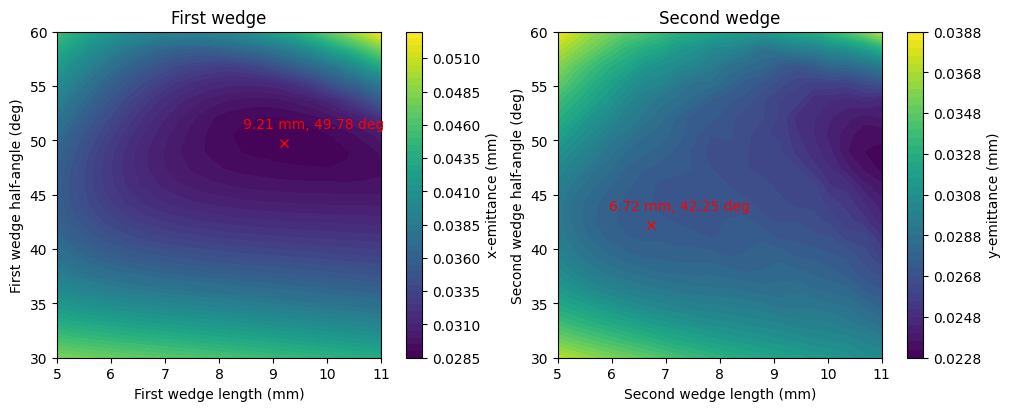

In [41]:
fig, (ax1, ax2) = plt.subplots(ncols=2, layout="constrained")
fig.set_size_inches(10, 4)

# First wedge

with open("results/first_wedge_length_angle.pkl", "rb") as file:
    results = pickle.load(file)

mesh = np.meshgrid(lengths, angles)
meshz = qmap_to_meshgrid(mesh, calc_quantity(lambda df: emittances(cut_outliers(df))[0], results))
meshx, meshy = mesh

cax = ax1.contourf(meshx, meshy, meshz, levels=50)
ax1.set_xlabel("First wedge length (mm)")
ax1.set_ylabel("First wedge half-angle (deg)")
ax1.set_title("First wedge")
plt.colorbar(cax, ax=ax1).set_label("x-emittance (mm)")

ax1.plot(w1_length, w1_angle, 'rx')
ax1.annotate(f"{w1_length:.2f} mm, {w1_angle:.2f} deg", (w1_length, w1_angle), c="red", xytext = (-30, 10), textcoords="offset points")

# Second wedge

with open("results/second_wedge_length_angle.pkl", "rb") as file:
    results = pickle.load(file)

mesh = np.meshgrid(lengths, angles)
meshz = qmap_to_meshgrid(mesh, calc_quantity(lambda df: emittances(cut_outliers(df))[1], results))
meshx, meshy = mesh

cax = ax2.contourf(meshx, meshy, meshz, levels=50)
ax2.set_xlabel("Second wedge length (mm)")
ax2.set_ylabel("Second wedge half-angle (deg)")
ax2.set_title("Second wedge")
plt.colorbar(cax, ax=ax2).set_label("y-emittance (mm)")

ax2.plot(w2_length, w2_angle, 'rx')
ax2.annotate(f"{w2_length:.2f} mm, {w2_angle:.2f} deg", (w2_length, w2_angle), c="red", xytext = (-30, 10), textcoords="offset points")

## Frequency and gradient (regenerated)

In [90]:
rf_freqs = np.linspace(0.01, 0.06, 20)
rf_grads = np.linspace(1,10,20)

In [91]:
# get no_transverse from above

def fun(rf_grad, rf_freq):
    return recenter_t(run_g4beam(no_transverse, "G4_RFCavity.g4bl", RF_length=rf_length, frfcool=rf_freq, ficool=rf_phase, Vrfcool=rf_grad))

results = run_scan(fun, (rf_grads, rf_freqs), "results/rf_grad_freq_16m.pkl")

100%|██████████████████████████████████████████████████████████████████████████████| 400/400 [2:41:22<00:00, 24.21s/it]


Text(-30, 10, '5.32 MV/m, 25.0 MHz')

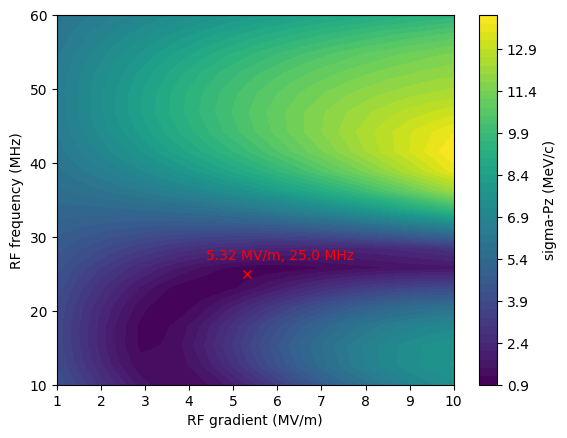

In [95]:
with open("results/rf_grad_freq_16m.pkl", "rb") as file:
    results = pickle.load(file)
mesh = np.meshgrid(rf_grads, rf_freqs)
meshz = qmap_to_meshgrid(mesh, calc_quantity(lambda df: np.std(cut_pz(df)["Pz"]), results))
meshx, meshy = mesh

meshy = 1000 * meshy # Scale to MHz

fig, ax = plt.subplots()
cax = ax.contourf(meshx, meshy, meshz, levels=50)
ax.set_xlabel("RF gradient (MV/m)")
ax.set_ylabel("RF frequency (MHz)")
plt.colorbar(cax).set_label("sigma-Pz (MeV/c)")

minpoint = np.unravel_index(np.argmin(meshz), meshz.shape)
ax.plot(rf_grad, rf_freq*1000, 'rx')
ax.annotate(f"{rf_grad:.2f} MV/m, {rf_freq*1000:.1f} MHz", (rf_grad, rf_freq*1000), c="red", xytext = (-30, 10), textcoords="offset points")

# Scan of optimal over pz_std

In [18]:
t_emit = 0.110  # mm
momentum = 100  # MeV/c
beta = 0.03    # m
alpha = 1     # dimensionless
l_emit = 1      # mm
pz_stds = np.linspace(0.8, 1.1, 6)
vd_dist = 24    # mm

In [107]:
# Meta-function (containing optimization)
def metafun(pz_std):
    pre_w1 = gen_distribution((beta, alpha, t_emit, 0, 0), (beta, alpha, t_emit, 0, 0), momentum, pz_std, z_emit=l_emit)
    
    def func(x):
        length, angle = x
        return emittances(cut_outliers(run_distribution(pre_w1, length, angle, vd_dist, axis=0)))[0]

    return scipy.optimize.minimize(func, [7.5, 45], method="Nelder-Mead", bounds=((1, 10), (30, 70)), options=dict(fatol=2e-4))

run_scan(metafun, (pz_stds,), filename="results/optimal_scan.pkl", trials=5)

100%|███████████████████████████████████████████████████████████████████████████████| 30/30 [5:11:31<00:00, 623.05s/it]


[(0.8,
         message: Optimization terminated successfully.
         success: True
          status: 0
             fun: 0.031168722970684147
               x: [ 6.475e+00  5.079e+01]
             nit: 36
            nfev: 78
   final_simplex: (array([[ 6.475e+00,  5.079e+01],
                         [ 6.475e+00,  5.079e+01],
                         [ 6.475e+00,  5.079e+01]]), array([ 3.117e-02,  3.117e-02,  3.117e-02]))),
 (0.8600000000000001,
         message: Optimization terminated successfully.
         success: True
          status: 0
             fun: 0.031267138258345435
               x: [ 6.249e+00  5.188e+01]
             nit: 37
            nfev: 85
   final_simplex: (array([[ 6.249e+00,  5.188e+01],
                         [ 6.249e+00,  5.188e+01],
                         [ 6.249e+00,  5.188e+01]]), array([ 3.127e-02,  3.127e-02,  3.127e-02]))),
 (0.92,
         message: Optimization terminated successfully.
         success: True
          status: 0
             f

Text(0, 0.5, 'optimal half-angle (deg)')

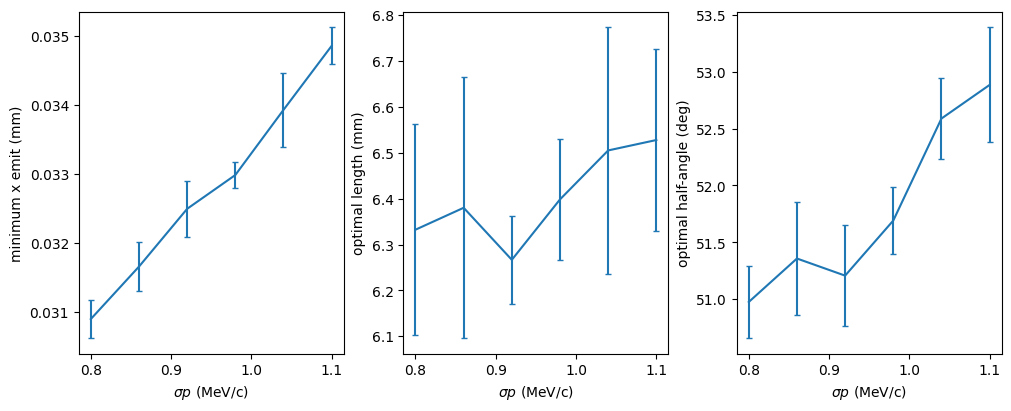

In [24]:
with open("results/optimal_scan.pkl", "rb") as file:
    results = pickle.load(file)

def optim_fun(optim_result):
    return optim_result.fun

def optim_x1(optim_result):
    return optim_result.x[0]

def optim_x2(optim_result):
    return optim_result.x[1]


fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, layout="constrained")
fig.set_size_inches(10, 4)
ax1.errorbar(*qmap_to_arrays(pz_stds, calc_quantity(optim_fun, results)), capsize=2)
ax1.set_xlabel(r"$\sigma p$ (MeV/c)")
ax1.set_ylabel("minimum x emit (mm)")

ax2.errorbar(*qmap_to_arrays(pz_stds, calc_quantity(optim_x1, results)), capsize=2)
ax2.set_xlabel(r"$\sigma p$ (MeV/c)")
ax2.set_ylabel("optimal length (mm)")

ax3.errorbar(*qmap_to_arrays(pz_stds, calc_quantity(optim_x2, results)), capsize=2)
ax3.set_xlabel(r"$\sigma p$ (MeV/c)")
ax3.set_ylabel("optimal half-angle (deg)")

In [99]:
calc_quantity(optim_fun, results)

{(0.8,): (0.03203172777361045, 0.00015658898234534674),
 (0.9,): (0.0331049797952, 0.00016108196351709628),
 (1.0,): (0.03450948901081038, 0.00046026497448378847),
 (1.1,): (0.036204002800201536, 0.0004105872173761963)}

In [100]:
1e-5

1e-05

In [105]:
calc_quantity(optim_fun, results)[(0.8,)][1] / 1e-4

1.5658898234534673